In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import random
import sys
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import tqdm
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from wisard.encoders import ThermometerEncoder
from wisard.wisard import WiSARD

%matplotlib inline

In [4]:
def sample_digit(target: int, X, y):
    return next((digit for (digit, label) in zip(X, y)
                 if int(label) == int(target))).reshape((28, 28))


def display_mnist_digits(X,
                         y,
                         figsize=(16, 8),
                         vmin: float = None,
                         vmax: float = None,
                         cmap: str = "gray"):
    fig, axs = plt.subplots(2, 5, figsize=figsize, constrained_layout=True)

    for i in range(2):
        for j in range(5):
            im = axs[i, j].imshow(
                sample_digit(target=5 * i + j, X=X, y=y),
                vmin=vmin,
                vmax=vmax,
                cmap=cmap,
            )
            axs[i, j].axes.xaxis.set_visible(False)
            axs[i, j].axes.yaxis.set_visible(False)
            if vmin is None or vmax is None:
                fig.colorbar(im, ax=axs[i, j], shrink=0.6)
    if vmin is not None and vmax is not None:
        fig.colorbar(im, ax=axs[:, 4], location="right", shrink=0.6)
    plt.show()


def train_model(model: WiSARD, X: np.ndarray, y: np.ndarray):
    for d in tqdm.tqdm(range(len(X)), desc="Training model", leave=True, position=0):
        model.train(X[d], y[d])


def evaluate_model(model, X, y, bleach: int = 1):
    model.set_bleaching(bleach)
    y_pred = [model.predict(x) for x in tqdm.tqdm(X, desc="Evaluating dataset", leave=True, position=0)]
    return y_pred


def untie(y_pred):
    final_pred = []
    ties = 0
    for pred in tqdm.tqdm(y_pred, desc="Untieing"):
        if len(pred) > 1:
            ties += 1
            # final_pred.append(pred[random.randint(0, len(pred) - 1)])
            final_pred.append(pred[0])
        else:
            final_pred.append(pred[0])

    return np.array(final_pred), ties

In [5]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True)

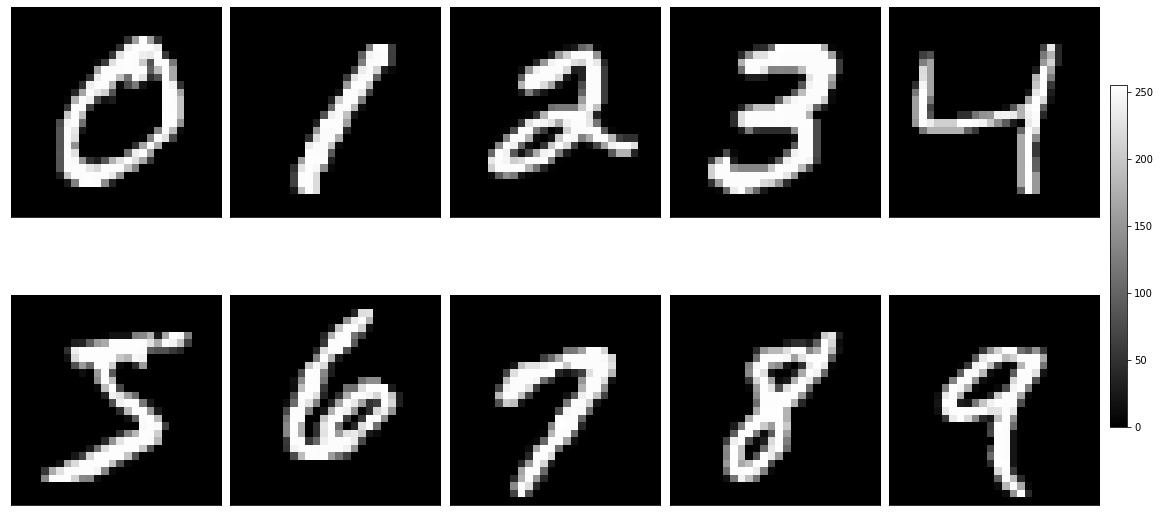

In [6]:
display_mnist_digits(X.values, y, vmin=0, vmax=255)

## Encoding example

Let's encode data with Thermometer

In [7]:
thermometer = ThermometerEncoder(minimum=0, maximum=255, resolution=16)
thermometer

ThermometerEncoder(minimum=0, maximum=255, resolution=16)

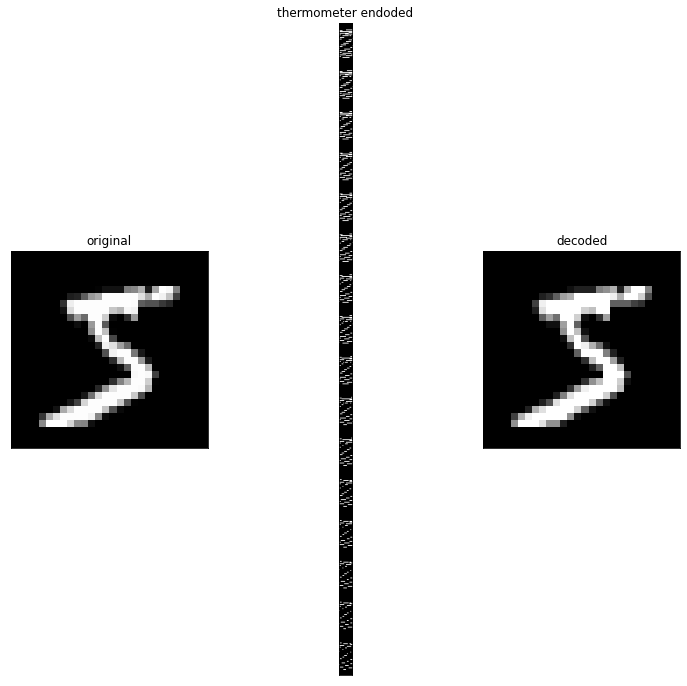

In [8]:
digit = X.values[0]
encoded_digit = thermometer.encode(digit).astype("int8")
decoded_digit = thermometer.decode(encoded_digit)

fig, axs = plt.subplots(1, 3, squeeze=False, figsize=(12, 12))

for i, (im, shape, name) in enumerate(
    [
        (digit, (28, 28), "original"),
        (encoded_digit, (28 * 28, 16), "thermometer endoded"),
        (decoded_digit, (28, 28), "decoded"),
    ]
):
    axs[0, i].imshow(im.reshape(shape), cmap="gray")
    axs[0, i].set_title(name)
    axs[0, i].axes.xaxis.set_visible(False)
    axs[0, i].axes.yaxis.set_visible(False)

plt.show()

In [9]:
coded_X = []
for x in tqdm.tqdm(X.values, desc="Encoding dataset"):
    coded_X.append(thermometer.encode(x).ravel().astype("int8"))

coded_X = np.array(coded_X)
y = np.array([int(label) for label in y.values])
print(coded_X.shape)

Encoding dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70000/70000 [00:06<00:00, 11310.74it/s]


(70000, 12544)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    coded_X, y, test_size=0.10, stratify=y
)

# Creating WiSARD

In [11]:
shared_rand_vals = True  # not used...
input_size = X_train[0].size
num_classes = 10
tuple_size = 8
unit_entries = 1  # Only used for BloomFilter
unit_hashes = 1  # Only used for BloomFilter
# input_idxs = np.random.shuffle(np.arange(input_size))  # Order to select elements
input_idxs = np.arange(input_size).reshape(thermometer.resolution, -1).T.ravel()
randomize = False  # Randomize selection order?

In [12]:
model_original = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=False,
)

In [13]:
train_model(model_original, X_train, y_train)

Training model: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63000/63000 [02:14<00:00, 467.79it/s]


In [14]:
y_pred = evaluate_model(model_original, X_test, y_test, bleach=250)
y_pred, ties = untie(y_pred)
print(classification_report(y_test, y_pred))
print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")

Untieing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:00<00:00, 1579180.72it/s]

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       690
           1       0.99      0.67      0.80       788
           2       0.78      0.73      0.76       699
           3       0.65      0.69      0.67       714
           4       0.82      0.48      0.60       682
           5       0.86      0.21      0.34       631
           6       0.88      0.85      0.87       688
           7       0.97      0.58      0.73       729
           8       0.33      0.87      0.48       683
           9       0.60      0.77      0.67       696

    accuracy                           0.68      7000
   macro avg       0.77      0.67      0.68      7000
weighted avg       0.78      0.68      0.68      7000

Ties: 537 (7.6714%)


# Mental images

In [15]:
imgs = model_original.mental_images()

Extracting mental images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.99it/s]


In [16]:
decoded_img_0s = [thermometer.decode(im[0].reshape(16, 784)) for im in imgs]
decoded_img_1s = [thermometer.decode(im[1].reshape(16, 784)) for im in imgs]

0.0 1762623.75


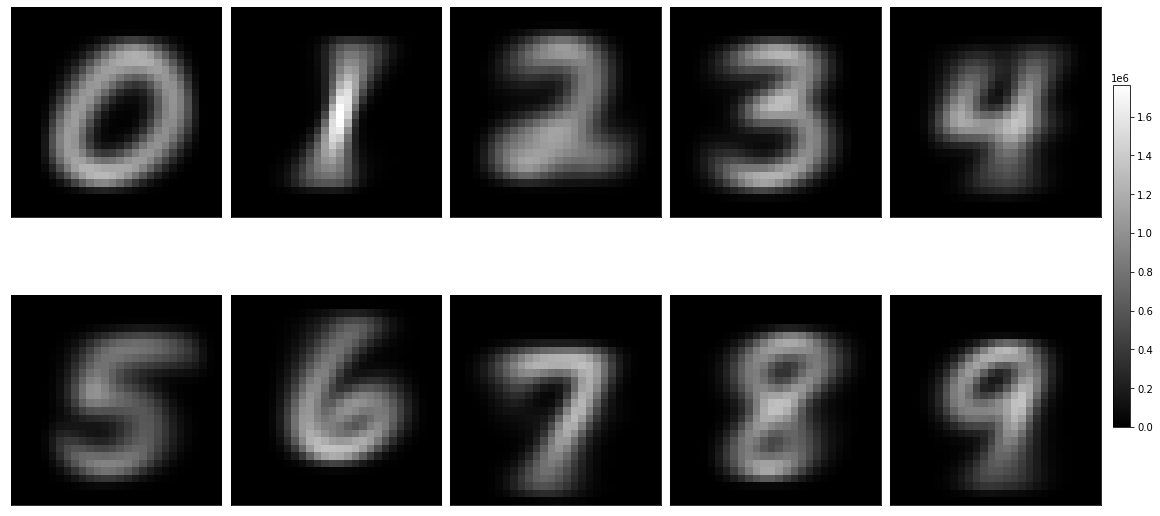

In [17]:
decoded_min = min(img.min() for img in decoded_img_1s)
decoded_max = max(img.max() for img in decoded_img_1s)
print(decoded_min, decoded_max)
display_mnist_digits(
    X=decoded_img_1s, y=list(range(10)), vmin=decoded_min, vmax=decoded_max)

45071.25 1807695.0


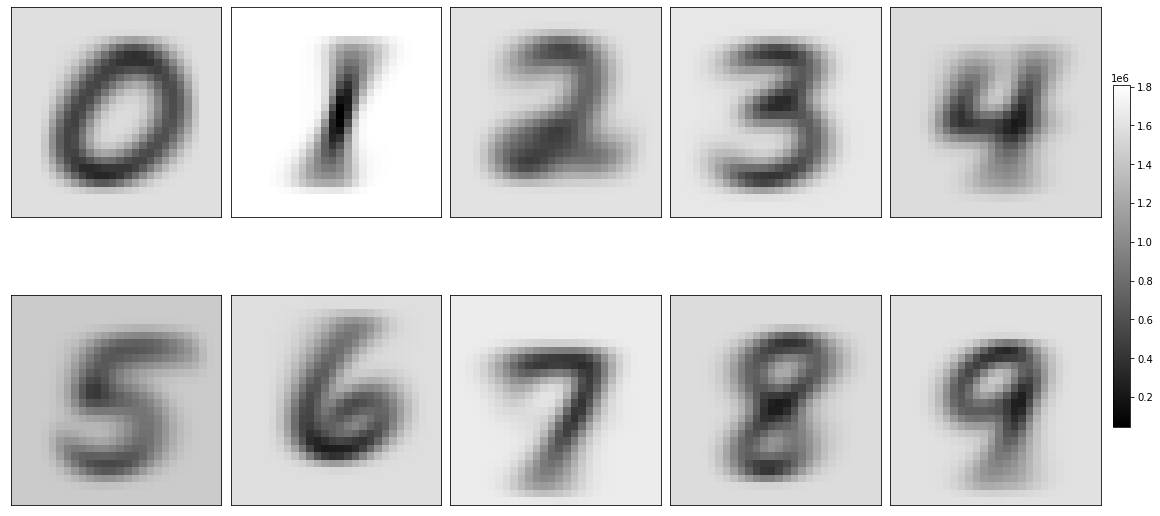

In [18]:
decoded_min = min(img.min() for img in decoded_img_0s)
decoded_max = max(img.max() for img in decoded_img_0s)
print(decoded_min, decoded_max)
display_mnist_digits(
    X=decoded_img_0s, y=list(range(10)), vmin=decoded_min, vmax=decoded_max)

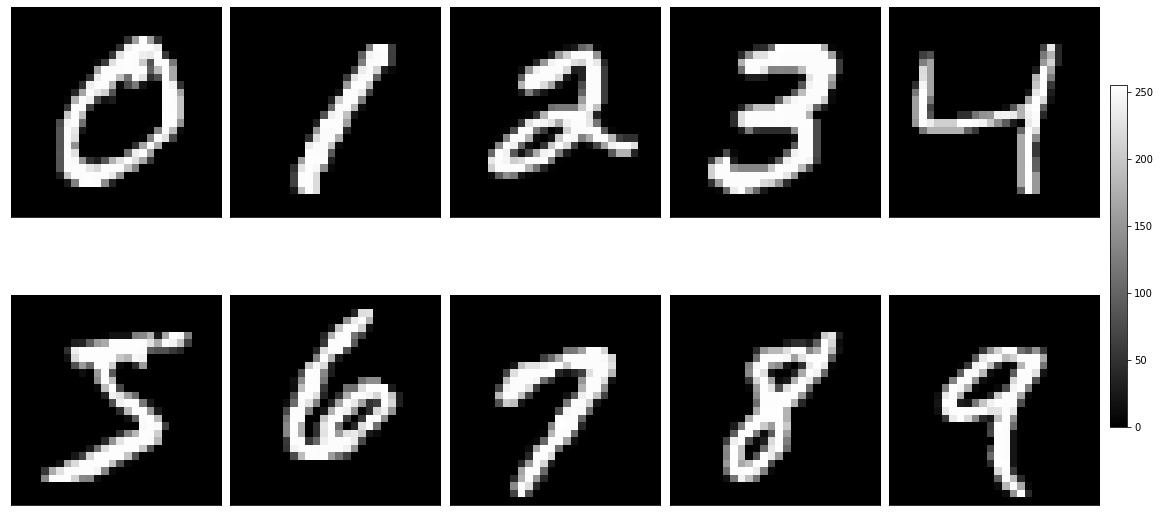

In [19]:
display_mnist_digits(X=X.values, y=y, vmin=0, vmax=255)

# Create a new WiSARD based on the mental images

In [20]:
from wisard.wisard import int_to_binary_list
def model_from_coded_mental_image(model, coded_images_0s, coded_images_1s):
    for d_no, (mental_img_0, mental_img_1) in enumerate(zip(coded_images_0s, coded_images_1s)):
        num_filters = model.discriminators[d_no].num_filters
        img_0 = mental_img_0[model.input_order].reshape(num_filters, -1)
        img_1 = mental_img_1[model.input_order].reshape(num_filters, -1)
        
        for f_no, ram_value in enumerate(img_1):
            original_ram_value = ram_value.copy()
            bin_addresses = np.asarray(int_to_binary_list(2**len(ram_value)-1))
            for i in reversed(range(len(ram_value))):
                if ram_value[i] > 0:
                    model.discriminators[d_no].filters[f_no].add_member(bin_addresses, ram_value[i])
                    for j in reversed(range(i)):
                        ram_value[j] -= ram_value[i]
                bin_addresses[i] = 0
            model.discriminators[d_no].filters[f_no].add_member(bin_addresses, img_0[f_no][0])

## Experiment 1: Replicating WiSARD based on mental images

The mapping is the same. The encoder/decoder method is the same (thermometer). The tuple size is the same.

In [21]:
model = WiSARD(
    num_inputs=input_size,
    num_classes=num_classes,
    unit_inputs=tuple_size,
    unit_entries=unit_entries,
    unit_hashes=unit_hashes,
    input_idxs=input_idxs,
    shared_rand_vals=shared_rand_vals,
    randomize=False,
)

model_from_coded_mental_image(model, [im[0] for im in imgs], [im[1] for im in imgs])

In [22]:
index = 120
non_zero_original = model_original.discriminators[0].filters[index].data.nonzero()[0]
non_zero = model.discriminators[0].filters[index].data.nonzero()[0]
print(model_original.discriminators[0].filters[index].data[non_zero_original])
print(model.discriminators[0].filters[index].data[non_zero])

[6212    1]
[6212    1]


In [23]:
def compare_wisards(w1, w2):
    all_equals = []
    for d_no in range(len(w1.discriminators)):
        equals = []
        # Just an logical AND will be suffice...
        for f_no in range(w1.discriminators[d_no].num_filters):
            eq = np.array_equal(w1.discriminators[d_no].filters[f_no].data, w2.discriminators[d_no].filters[f_no].data)
            equals.append(eq)
        all_equals.append(all(equals))
    return all_equals

In [24]:
compare_wisards(model, model_original)

[True, True, True, True, True, True, True, True, True, True]

In [25]:
y_pred = evaluate_model(model, X_test, y_test, bleach=250)
y_pred, ties = untie(y_pred)
print(classification_report(y_test, y_pred))
print(f"Ties: {ties} ({(ties/len(y_pred))*100:.4f}%)")

Untieing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7000/7000 [00:00<00:00, 1345622.07it/s]

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       690
           1       0.99      0.67      0.80       788
           2       0.78      0.73      0.76       699
           3       0.65      0.69      0.67       714
           4       0.82      0.48      0.60       682
           5       0.86      0.21      0.34       631
           6       0.88      0.85      0.87       688
           7       0.97      0.58      0.73       729
           8       0.33      0.87      0.48       683
           9       0.60      0.77      0.67       696

    accuracy                           0.68      7000
   macro avg       0.77      0.67      0.68      7000
weighted avg       0.78      0.68      0.68      7000

Ties: 537 (7.6714%)


In [26]:
new_imgs = model.mental_images()

Extracting mental images: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.95it/s]


In [27]:
decoded_img_0s = [thermometer.decode(im[0].reshape(16, 784)) for im in new_imgs]
decoded_img_1s = [thermometer.decode(im[1].reshape(16, 784)) for im in new_imgs]

0.0 1762623.75


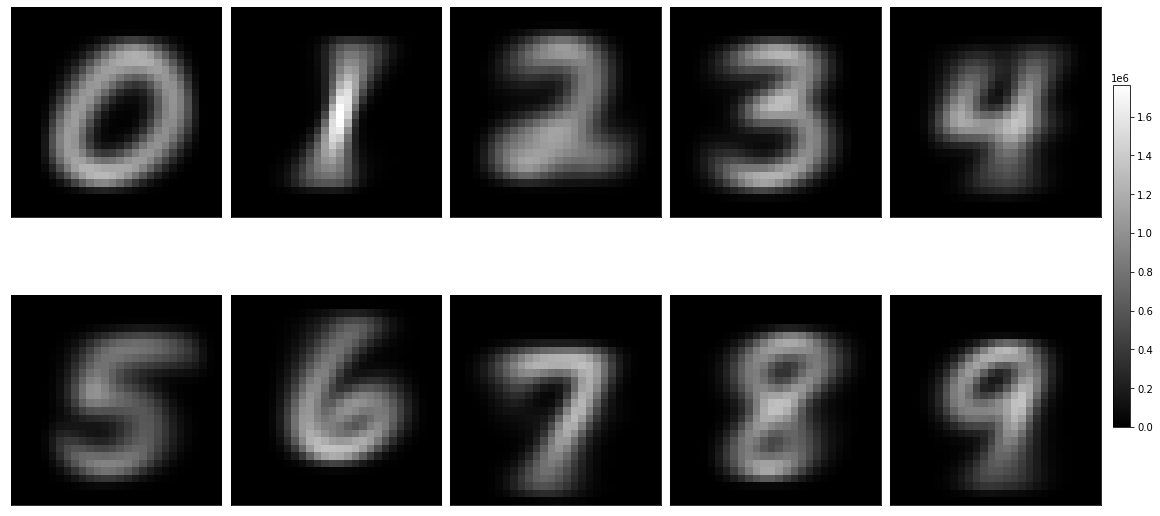

In [28]:
decoded_min = min(img.min() for img in decoded_img_1s)
decoded_max = max(img.max() for img in decoded_img_1s)
print(decoded_min, decoded_max)
display_mnist_digits(
    X=decoded_img_1s, y=list(range(10)), vmin=decoded_min, vmax=decoded_max)

45071.25 1807695.0


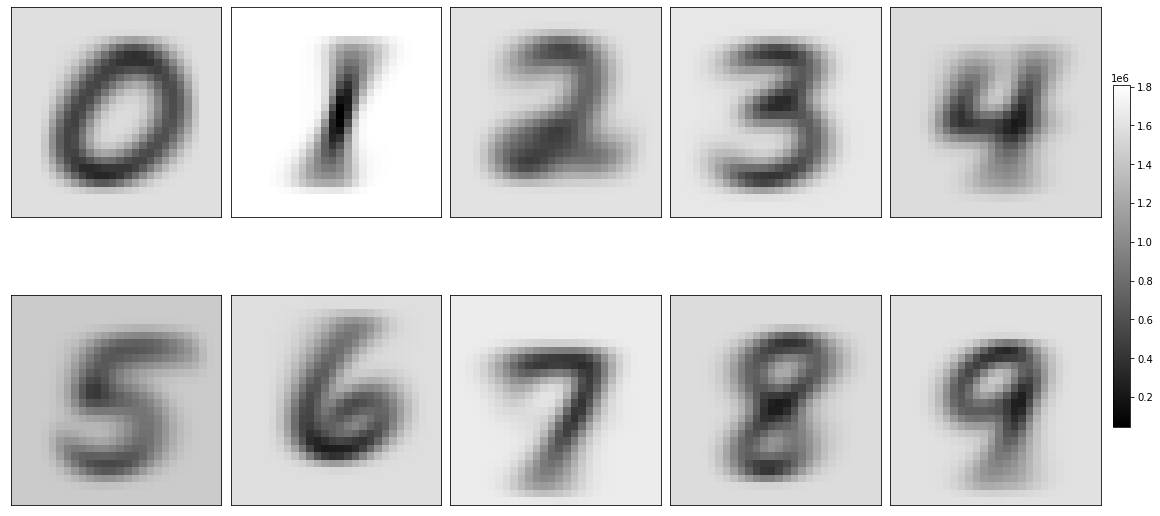

In [29]:
decoded_min = min(img.min() for img in decoded_img_0s)
decoded_max = max(img.max() for img in decoded_img_0s)
print(decoded_min, decoded_max)
display_mnist_digits(
    X=decoded_img_0s, y=list(range(10)), vmin=decoded_min, vmax=decoded_max)

# From mental image from SUM of coded images

In [30]:
new_imgs = []
for i in range(num_classes):
    res_1s = sum([(_x.astype(bool))*1 for _x, _y in zip(X_train, y_train) if _y == i])
    res_0s = sum([np.invert(_x.astype(bool))*1 for _x, _y in zip(X_train, y_train) if _y == i])
    new_imgs.append((res_0s, res_1s))

In [31]:
decoded_img_0s = [thermometer.decode(im[0].reshape(16, 784)) for im in new_imgs]
decoded_img_1s = [thermometer.decode(im[1].reshape(16, 784)) for im in new_imgs]

0.0 1762623.75


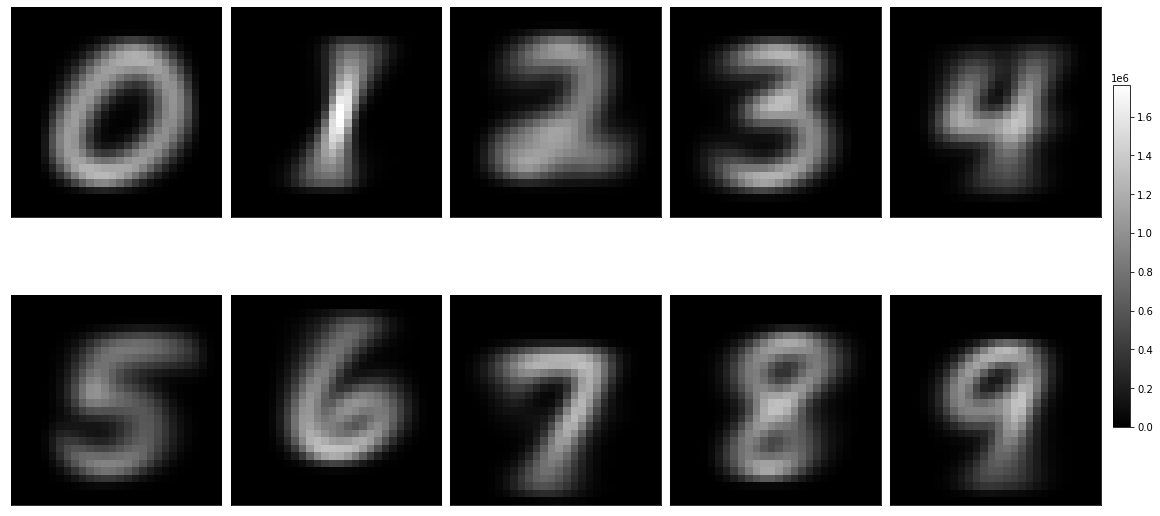

In [32]:
decoded_min = min(img.min() for img in decoded_img_1s)
decoded_max = max(img.max() for img in decoded_img_1s)
print(decoded_min, decoded_max)
display_mnist_digits(
    X=decoded_img_1s, y=list(range(10)), vmin=decoded_min, vmax=decoded_max)

45071.25 1807695.0


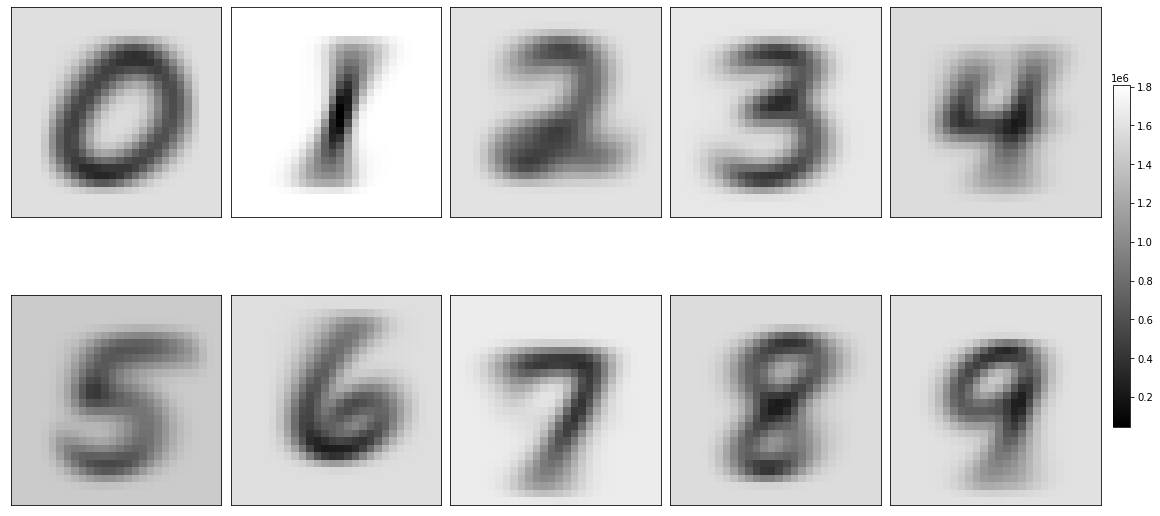

In [33]:
decoded_min = min(img.min() for img in decoded_img_0s)
decoded_max = max(img.max() for img in decoded_img_0s)
print(decoded_min, decoded_max)
display_mnist_digits(
    X=decoded_img_0s, y=list(range(10)), vmin=decoded_min, vmax=decoded_max)

In [34]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b) ** 2))

In [35]:
for i, ((img_0s, img_1s), (new_img_0s, new_img_1s)) in enumerate(zip(imgs, new_imgs)):
    loss_0s, loss_1s = rmse(img_0s, new_img_0s), rmse(img_1s, new_img_1s)
    print(f"RMSE from class {i}: zeros {loss_0s}, ones {loss_1s}")

RMSE from class 0: zeros 0.0, ones 0.0
RMSE from class 1: zeros 0.0, ones 0.0
RMSE from class 2: zeros 0.0, ones 0.0
RMSE from class 3: zeros 0.0, ones 0.0
RMSE from class 4: zeros 0.0, ones 0.0
RMSE from class 5: zeros 0.0, ones 0.0
RMSE from class 6: zeros 0.0, ones 0.0
RMSE from class 7: zeros 0.0, ones 0.0
RMSE from class 8: zeros 0.0, ones 0.0
RMSE from class 9: zeros 0.0, ones 0.0
